In [167]:
import itertools
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy.stats as stats
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests

# sns.set_theme(style="whitegrid", palette="gray", font_scale=1.4)
sns.set_theme(style="whitegrid", font_scale=2.0)
# save_dir = Path("~/class/research/master_thesis/figure/sec4").expanduser()
save_dir = Path("~/dev/nextjs/subjective-evaluation-test-2/src_py/figs").expanduser()

In [135]:
def calculate_t_value(sample_size: int, alpha: float) -> float:
    """
    Calculates the critical t-value for a given sample size and significance level.

    Args:
        sample_size (int): Number of samples.
        alpha (float): Significance level (e.g., 0.05 for 95% confidence).

    Returns:
        float: Critical t-value.
    """
    df = sample_size - 1
    alpha_half = alpha / 2
    t_value = stats.t.ppf(1 - alpha_half, df)
    return t_value


def calculate_summary_stats(
    df_answer: pl.DataFrame, colname: str, n_sample: int, t_value: float
) -> pl.DataFrame:
    """
    Calculates summary statistics (mean, standard error, lower and upper confidence limits)
    for a given column in a DataFrame, grouped by 'model_id', 'model_name', and 'kind'.

    Args:
        df_answer (pl.DataFrame): Input DataFrame containing the data.
        colname (str): Name of the column to calculate statistics for. Must be 'intelligibility_id' or 'naturalness_id'.
        n_sample (int): Number of samples.
        t_value (float): Critical t-value for confidence interval calculation.

    Returns:
        pl.DataFrame: DataFrame containing the calculated summary statistics.

    Raises:
        ValueError: If the column name is not 'intelligibility_id' or 'naturalness_id'.
    """
    if colname not in ["intelligibility_id", "naturalness_id"]:
        raise ValueError("Column name must be 'intelligibility_id' or 'naturalness_id'")

    df = (
        df_answer.group_by(["model_id", "model_name", "kind"])
        .agg(
            pl.col(colname).mean().alias("mean"),
            (pl.col(colname).std() / math.sqrt(n_sample)).alias("se"),
        )
        .with_columns(
            (pl.col("mean") - t_value * pl.col("se")).alias("lcl"),
            (pl.col("mean") + t_value * pl.col("se")).alias("ucl"),
        )
        .sort(["mean"], descending=False)
    )
    return df


def hypothesis_testing(
    df_summary_stats: pl.DataFrame,
    df_answer: pl.DataFrame,
    colname: str,
    alpha: float,
) -> pl.DataFrame:
    """
    Performs hypothesis testing (t-test and Mann-Whitney U test) on a given column across different models.

    Args:
        df_summary_stats (pl.DataFrame): DataFrame containing summary statistics of models.
        df_answer (pl.DataFrame): DataFrame containing the answer data.
        colname (str): Name of the column to test. Must be 'intelligibility' or 'naturalness'.
        alpha (float): Significance level for the hypothesis tests.

    Returns:
        pl.DataFrame: DataFrame containing the test results with p-values and multiple testing corrections.

    Raises:
        ValueError: If the column name is not 'intelligibility' or 'naturalness'.
    """
    if colname not in ["intelligibility", "naturalness"]:
        raise ValueError("Column name must be 'intelligibility' or 'naturalness'")

    df_summary_stats = df_summary_stats.sort(["mean"], descending=True)
    model_id_order = list(df_summary_stats["model_id"].to_numpy().reshape(-1))
    model_id_order_combination = list(itertools.combinations(model_id_order, 2))
    test_result = {
        "model_id_high": [],
        "model_id_low": [],
        f"ttest_{colname}_pvalue": [],
        f"ttest_{colname}_pvalue_corrected_bonf": [],
        f"ttest_{colname}_is_rejected_bonf": [],
        f"ttest_{colname}_pvalue_corrected_bh": [],
        f"ttest_{colname}_is_rejected_bh": [],
        f"mannwhitneyu_{colname}_pvalue": [],
        f"mannwhitneyu_{colname}_pvalue_corrected_bonf": [],
        f"mannwhitneyu_{colname}_is_rejected_bonf": [],
        f"mannwhitneyu_{colname}_pvalue_corrected_bh": [],
        f"mannwhitneyu_{colname}_is_rejected_bh": [],
    }

    for model_id_high, model_id_low in model_id_order_combination:
        data_high = df_answer.filter(pl.col("model_id") == str(model_id_high))
        data_low = df_answer.filter(pl.col("model_id") == str(model_id_low))
        vals_high = data_high.select(pl.col(f"{colname}_id")).to_numpy().reshape(-1)
        vals_low = data_low.select(pl.col(f"{colname}_id")).to_numpy().reshape(-1)

        result_ttest = ttest_ind(
            a=vals_high,
            b=vals_low,
            axis=0,
            equal_var=False,
            nan_policy="raise",
            permutations=0,
            random_state=42,
            alternative="greater",
            trim=0,
            keepdims=False,
        )

        result_mannwhitneyu = mannwhitneyu(
            x=vals_high,
            y=vals_low,
            use_continuity=True,
            alternative="greater",
            axis=0,
            method="asymptotic",
            nan_policy="raise",
            keepdims=False,
        )

        test_result["model_id_high"].append(model_id_high)
        test_result["model_id_low"].append(model_id_low)
        test_result[f"ttest_{colname}_pvalue"].append(result_ttest.pvalue)
        test_result[f"mannwhitneyu_{colname}_pvalue"].append(result_mannwhitneyu.pvalue)

    for name in [
        f"ttest_{colname}_pvalue",
        f"mannwhitneyu_{colname}_pvalue",
    ]:
        reject_bonf, pvals_corrected_bonf, _, _ = multipletests(
            pvals=test_result[name],
            alpha=alpha,
            method="bonferroni",
            is_sorted=False,
            returnsorted=False,
        )

        reject_bh, pvals_corrected_bh, _, _ = multipletests(
            pvals=test_result[name],
            alpha=alpha,
            method="fdr_bh",
            is_sorted=False,
            returnsorted=False,
        )

        common_part = name.replace("_pvalue", "")
        test_result[f"{common_part}_pvalue_corrected_bonf"] = pvals_corrected_bonf
        test_result[f"{common_part}_is_rejected_bonf"] = reject_bonf
        test_result[f"{common_part}_pvalue_corrected_bh"] = pvals_corrected_bh
        test_result[f"{common_part}_is_rejected_bh"] = reject_bh

    df_result = pl.DataFrame(data=test_result)
    return df_result


def display_score_pct_bar_plot(
    df_answer: pl.DataFrame,
    df_summary_stats: pl.DataFrame,
    colname: str,
    save_path: str,
) -> None:
    """
    Displays a bar plot of score percentages based on the provided dataframe.

    Args:
        df_answer (pl.DataFrame): DataFrame containing the answers with model_id and score columns.
        df_summary_stats (pl.DataFrame): DataFrame containing summary statistics.
        colname (str): The column name to use for grouping and plotting ('intelligibility_id' or 'naturalness_id').
        filename (str): The filename to save the resulting plot as a PNG file.

    Raises:
        ValueError: If colname is not 'intelligibility_id' or 'naturalness_id'.

    Returns:
        None
    """
    if colname not in ["intelligibility_id", "naturalness_id"]:
        raise ValueError("Column name must be 'intelligibility_id' or 'naturalness_id'")

    data_tmp = {
        "model_id": [],
        colname: [],
    }
    for model_id in df_answer["model_id"].unique().to_numpy().reshape(-1):
        for intelligibility_id in range(1, 6):
            data_tmp["model_id"].append(model_id)
            data_tmp[colname].append(intelligibility_id)

    df_answer_int_len = (
        pl.DataFrame(data=data_tmp)
        .join(
            df_answer.group_by(["model_id", colname]).len().sort(["model_id", colname]),
            on=["model_id", colname],
            how="left",
            coalesce=True,
        )
        .with_columns(pl.col("len").fill_null(0))
        .join(
            df_answer.group_by(["model_id"]).len().rename({"len": "total"}),
            on=["model_id"],
            how="left",
            coalesce=True,
        )
        .with_columns((pl.col("len") / pl.col("total") * 100).alias("pct"))
        .sort(["model_id", colname], descending=False)
    )

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
    model_id = df_summary_stats["model_id"].to_numpy().reshape(-1)
    model_id_to_order = {category: i for i, category in enumerate(model_id)}
    bottom = None
    for label in range(1, 6):
        data = (
            df_answer_int_len.filter(pl.col(colname) == label)
            .select(pl.col("model_id"), pl.col("pct"))
            .to_numpy()
        )
        data = np.array(sorted(data, key=lambda x: model_id_to_order[x[0]]))
        x = np.array([data[i][0] for i in range(data.shape[0])])
        y = np.array([data[i][1] for i in range(data.shape[0])])

        ax.bar(
            x=x,
            height=y,
            width=0.5,
            label=label,
            bottom=bottom,
        )
        if bottom is None:
            bottom = y
        else:
            bottom = bottom + y

    ax.set_xlabel("model_id")
    ax.set_ylabel("Percentage [%]")
    ax.set_ylim(0, 100)
    ax.legend(bbox_to_anchor=(1, 1), title=colname, frameon=False)
    fig.tight_layout()
    fig.savefig(save_path)
    plt.show()


def display_mean_point_plot(
    df_answer: pl.DataFrame,
    df_summary_stats: pl.DataFrame,
    t_value: float,
    colname: str,
    save_path: str,
) -> None:
    """
    Displays a point plot of mean values with error bars based on the provided dataframe.

    Args:
        df_answer (pl.DataFrame): DataFrame containing the answers with model_id and score columns.
        df_summary_stats (pl.DataFrame): DataFrame containing summary statistics.
        t_value (float): The t-value for calculating the error bars.
        colname (str): The column name to use for plotting the mean values.
        save_path (str): The path to save the resulting plot as a PNG file.

    Returns:
        None
    """
    if colname not in ["intelligibility_id", "naturalness_id"]:
        raise ValueError("Column name must be 'intelligibility_id' or 'naturalness_id'")

    fg = sns.catplot(
        data=df_answer,
        x="model_id",
        y=colname,
        order=[str(x) for x in df_summary_stats["model_id"].to_numpy().reshape(-1)],
        kind="point",
        errorbar=("se", t_value),
        n_boot=5000,
        seed=42,
        legend="full",
        height=4.0,
        aspect=3.0,
    )
    fg.savefig(save_path)

In [136]:
df_sample = pl.read_csv("./result/SampleMetaData_rows.csv")
df_sample = df_sample.rename({"id": "sample_meta_data_id"})
df_sample.group_by(["model_id", "model_name", "kind"]).len().sort(["model_id"])

model_id,model_name,kind,len
i64,str,str,u32
-1,"""dummy""","""dummy""",3
0,"""20240621_134621""","""abs""",212
1,"""20240621_134621""","""gt""",212
2,"""20240621_134621""","""pred""",212
3,"""20240621_155144""","""pred""",212
4,"""20240621_202419""","""pred""",212
5,"""20240622_003027""","""pred""",212
6,"""20240622_103111""","""pred""",212
7,"""20240622_161416""","""pred""",212


In [137]:
df_answer = pl.read_csv("./result/Answers_rows.csv")
df_sample = pl.read_csv("./result/SampleMetaData_rows.csv")
df_sample = df_sample.rename({"id": "sample_meta_data_id"})
df_respondent = pl.read_csv("./result/Respondents_rows.csv")
df_respondent = df_respondent.rename({"id": "respondent_id"})

df_respondent = df_respondent.with_columns(
    pl.col("sex").replace({"男性": "M", "女性": "F", "無回答": "N"}),
    pl.col("audio_device").replace({"イヤホン": "Earphone", "ヘッドホン": "Headphone"}),
)

df_sample = df_sample.with_columns(
    pl.col("model_id").replace(
        {
            0: "(4)",  # 分析合成
            1: "(5)",  # 原音声
            2: "(1)",  # ベースライン
            3: "(2-a)",  # HuBERTなし メル・連続
            4: "(2-b)",  # HuBERTなし メル・離散
            5: "(2-c)",  # HuBERTなし メル・連続・離散
            6: "(3-a)",  # HuBERTあり メル・連続
            7: "(3-c)",  # HuBERTあり メル・連続・離散
            8: "(3-b)",  # HuBERTあり メル・離散
        }
    )
)

df_answer = df_answer.join(
    other=df_sample, on=["sample_meta_data_id"], how="left", coalesce=True
)
df_answer = df_answer.join(
    other=df_respondent,
    on="respondent_id",
    how="left",
    coalesce=True,
)
df_answer = df_answer.filter(
    pl.col("is_dummy").not_()
    & pl.col("is_invalid").not_()
    & (pl.col("sample_page_name") == "eval_1")
)

In [138]:
df_respondent.group_by(["sex"]).len()

sex,len
str,u32
"""M""",45
"""F""",63


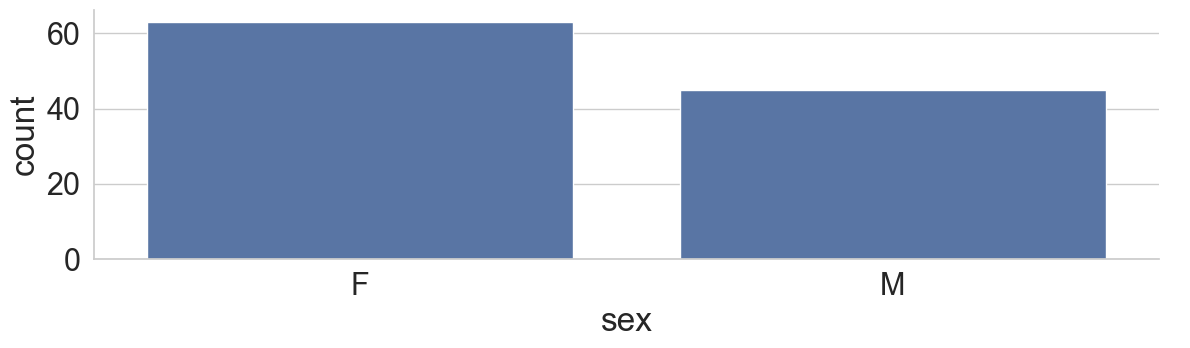

In [139]:
fg = sns.catplot(
    data=df_respondent,
    x="sex",
    kind="count",
    height=4.0,
    aspect=3.0,
)
fg.savefig(str(save_dir / "sex.png"))
# fg.savefig("./figs/sex.png")

In [140]:
df_respondent.group_by(["audio_device"]).len()

audio_device,len
str,u32
"""Earphone""",79
"""Headphone""",29


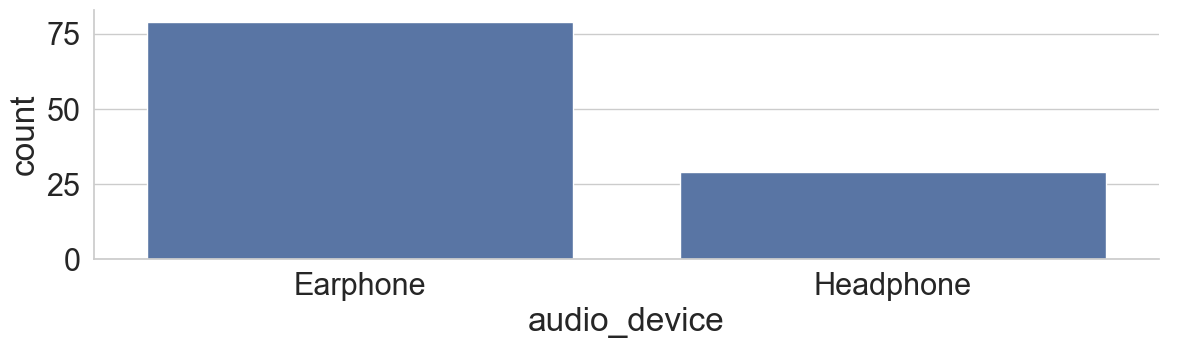

In [141]:
fg = sns.catplot(
    data=df_respondent,
    x="audio_device",
    kind="count",
    height=4.0,
    aspect=3.0,
)
fg.savefig(str(save_dir / "audio_device.png"))
# fg.savefig("./figs/audio_device.png")

In [142]:
df_answer["age"].describe()

statistic,value
str,f64
"""count""",4752.0
"""null_count""",0.0
"""mean""",41.231481
"""std""",9.577799
"""min""",19.0
"""25%""",35.0
"""50%""",42.0
"""75%""",47.0
"""max""",67.0


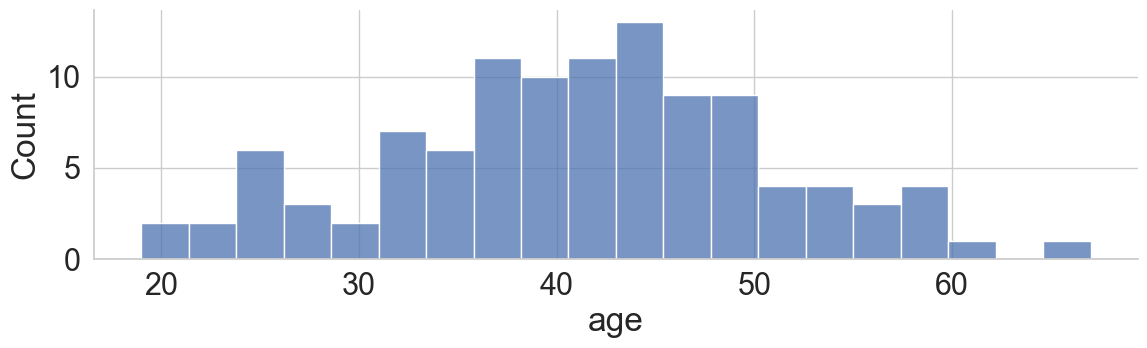

In [143]:
fg = sns.displot(
    data=df_respondent,
    x="age",
    kind="hist",
    bins=20,
    height=4.0,
    aspect=3.0,
)
fg.savefig(str(save_dir / "respondent_dist.png"))

In [144]:
if (
    df_answer.group_by(["model_id"])
    .len()
    .unique(["len"])["len"]
    .to_numpy()
    .reshape(-1)
    .shape[0]
    != 1
):
    raise ValueError()

n_sample = (
    df_answer.group_by(["model_id"])
    .len()
    .unique(["len"])["len"]
    .to_numpy()
    .reshape(-1)[0]
)
alpha = 0.05
t_value = calculate_t_value(n_sample, alpha)
print(f"n_sample = {n_sample}")
print(f"t_value = {t_value}")

n_sample = 528
t_value = 1.964475628237745


In [145]:
df_summary_stats_intelligibility = calculate_summary_stats(
    df_answer=df_answer,
    colname="intelligibility_id",
    n_sample=n_sample,
    t_value=t_value,
)

df_summary_stats_intelligibility

model_id,model_name,kind,mean,se,lcl,ucl
str,str,str,f64,f64,f64,f64
"""(3-a)""","""20240622_103111""","""pred""",1.613636,0.031675,1.551411,1.675862
"""(2-a)""","""20240621_155144""","""pred""",1.715909,0.035027,1.6471,1.784718
"""(1)""","""20240621_134621""","""pred""",1.854167,0.035047,1.785319,1.923015
"""(2-c)""","""20240622_003027""","""pred""",1.890152,0.037516,1.816453,1.963851
"""(3-c)""","""20240622_161416""","""pred""",1.986742,0.038985,1.910157,2.063328
"""(3-b)""","""20240623_001016""","""pred""",2.003788,0.04136,1.922538,2.085038
"""(2-b)""","""20240621_202419""","""pred""",2.028409,0.037657,1.954433,2.102385
"""(4)""","""20240621_134621""","""abs""",3.873106,0.046532,3.781694,3.964518
"""(5)""","""20240621_134621""","""gt""",4.63447,0.028401,4.578676,4.690264


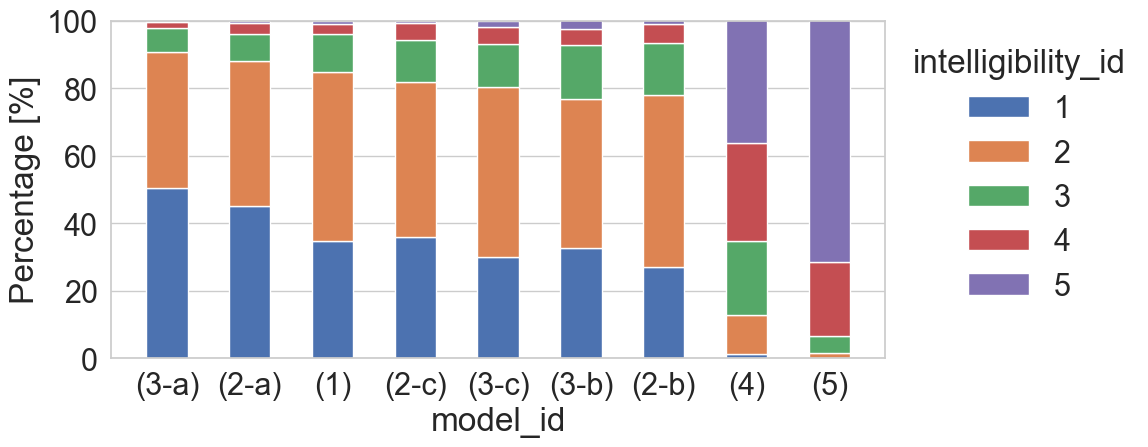

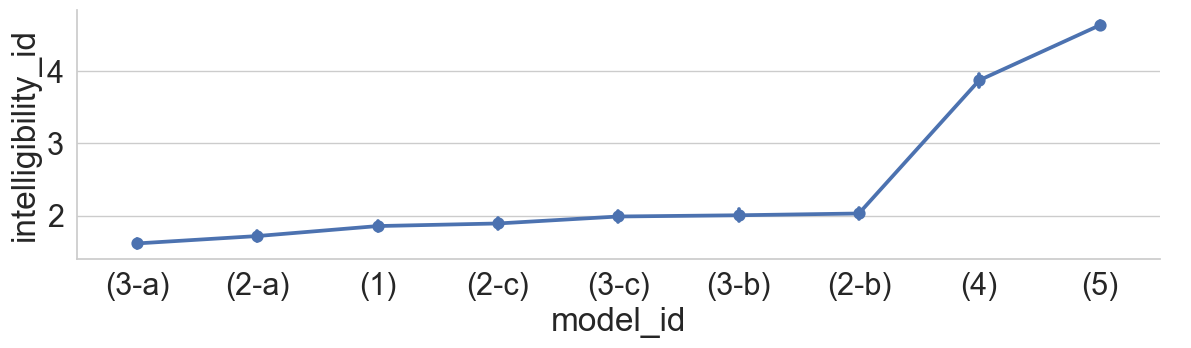

In [146]:
display_score_pct_bar_plot(
    df_answer=df_answer,
    df_summary_stats=df_summary_stats_intelligibility,
    colname="intelligibility_id",
    # save_path="./figs/int_score_pct.png",
    save_path=str(save_dir / "int_score_pct.png"),
)

display_mean_point_plot(
    df_answer=df_answer,
    df_summary_stats=df_summary_stats_intelligibility,
    t_value=t_value,
    colname="intelligibility_id",
    # save_path="./figs/int_summary_stats.png",
    save_path=str(save_dir / "int_summary_stats.png"),
)

In [147]:
df_htest_result_intelligibility = hypothesis_testing(
    df_summary_stats=df_summary_stats_intelligibility,
    df_answer=df_answer,
    colname="intelligibility",
    alpha=alpha,
)

In [148]:
df_htest_result_intelligibility.pivot(
    values=["ttest_intelligibility_pvalue_corrected_bonf"],
    index="model_id_high",
    columns="model_id_low",
)

model_id_high,(4),(2-b),(3-b),(3-c),(2-c),(1),(2-a),(3-a)
str,f64,f64,f64,f64,f64,f64,f64,f64
"""(5)""",6.7742e-39,4.7336e-302,3.2673e-279,1.3359e-297,5.6383e-320,0.0,0.0,0.0
"""(4)""",null,2.7537e-146,6.9859e-142,1.4680e-148,1.6535e-162,3.7334e-171,3.5281e-187,7.0683e-204
"""(2-b)""",null,null,1.0,1.0,0.169647,0.013184,3.0923e-8,2.1060e-15
"""(3-b)""",null,null,null,1.0,0.757769,0.10591,0.000002,2.7641e-12
"""(3-c)""",null,null,null,null,1.0,0.208543,0.000005,4.2183e-12
"""(2-c)""",null,null,null,null,null,1.0,0.012823,4.1460e-7
"""(1)""",null,null,null,null,null,null,0.096496,0.000008
"""(2-a)""",null,null,null,null,null,null,null,0.550157


In [149]:
df_htest_result_intelligibility.pivot(
    values=["ttest_intelligibility_is_rejected_bonf"],
    index="model_id_high",
    columns="model_id_low",
)

model_id_high,(4),(2-b),(3-b),(3-c),(2-c),(1),(2-a),(3-a)
str,bool,bool,bool,bool,bool,bool,bool,bool
"""(5)""",true,true,true,true,true,true,true,true
"""(4)""",null,true,true,true,true,true,true,true
"""(2-b)""",null,null,false,false,false,true,true,true
"""(3-b)""",null,null,null,false,false,false,true,true
"""(3-c)""",null,null,null,null,false,false,true,true
"""(2-c)""",null,null,null,null,null,false,true,true
"""(1)""",null,null,null,null,null,null,false,true
"""(2-a)""",null,null,null,null,null,null,null,false


In [150]:
df_htest_result_intelligibility.pivot(
    values=["ttest_intelligibility_pvalue_corrected_bh"],
    index="model_id_high",
    columns="model_id_low",
)

model_id_high,(4),(2-b),(3-b),(3-c),(2-c),(1),(2-a),(3-a)
str,f64,f64,f64,f64,f64,f64,f64,f64
"""(5)""",4.5162e-40,9.4673e-303,4.6676e-280,2.2266e-298,1.4096e-320,0.0,0.0,0.0
"""(4)""",null,2.1182e-147,4.9900e-143,1.2233e-149,1.5032e-163,3.7334e-172,3.9201e-188,8.8353e-205
"""(2-b)""",null,null,0.339376,0.241215,0.006059,0.000527,1.6275e-9,1.3162e-16
"""(3-b)""",null,null,null,0.382157,0.024444,0.003923,1.1424e-7,1.6260e-13
"""(3-c)""",null,null,null,null,0.04191,0.007191,2.3235e-7,2.3435e-13
"""(2-c)""",null,null,null,null,null,0.255973,0.000527,2.0730e-8
"""(1)""",null,null,null,null,null,null,0.003711,3.2935e-7
"""(2-a)""",null,null,null,null,null,null,null,0.018339


In [151]:
df_htest_result_intelligibility.pivot(
    values=["ttest_intelligibility_is_rejected_bh"],
    index="model_id_high",
    columns="model_id_low",
)

model_id_high,(4),(2-b),(3-b),(3-c),(2-c),(1),(2-a),(3-a)
str,bool,bool,bool,bool,bool,bool,bool,bool
"""(5)""",true,true,true,true,true,true,true,true
"""(4)""",null,true,true,true,true,true,true,true
"""(2-b)""",null,null,false,false,true,true,true,true
"""(3-b)""",null,null,null,false,true,true,true,true
"""(3-c)""",null,null,null,null,true,true,true,true
"""(2-c)""",null,null,null,null,null,false,true,true
"""(1)""",null,null,null,null,null,null,true,true
"""(2-a)""",null,null,null,null,null,null,null,true


In [152]:
df_htest_result_intelligibility.pivot(
    values=["mannwhitneyu_intelligibility_pvalue_corrected_bonf"],
    index="model_id_high",
    columns="model_id_low",
)

model_id_high,(4),(2-b),(3-b),(3-c),(2-c),(1),(2-a),(3-a)
str,f64,f64,f64,f64,f64,f64,f64,f64
"""(5)""",1.9625e-36,1.1896e-166,1.8600e-161,8.2822e-165,1.4604e-169,7.2376e-172,8.4840e-174,3.9703e-178
"""(4)""",null,1.0575e-110,1.3430e-107,5.0165e-112,5.7964e-119,2.3851e-124,1.0938e-131,1.6478e-140
"""(2-b)""",null,null,1.0,1.0,0.062028,0.011449,1.2194e-9,4.6288e-16
"""(3-b)""",null,null,null,1.0,1.0,0.503018,0.000003,2.5046e-11
"""(3-c)""",null,null,null,null,1.0,0.446238,0.000001,3.4344e-12
"""(2-c)""",null,null,null,null,null,1.0,0.00718,8.1092e-7
"""(1)""",null,null,null,null,null,null,0.016864,0.000002
"""(2-a)""",null,null,null,null,null,null,null,0.937443


In [153]:
df_htest_result_intelligibility.pivot(
    values=["mannwhitneyu_intelligibility_is_rejected_bonf"],
    index="model_id_high",
    columns="model_id_low",
)

model_id_high,(4),(2-b),(3-b),(3-c),(2-c),(1),(2-a),(3-a)
str,bool,bool,bool,bool,bool,bool,bool,bool
"""(5)""",true,true,true,true,true,true,true,true
"""(4)""",null,true,true,true,true,true,true,true
"""(2-b)""",null,null,false,false,false,true,true,true
"""(3-b)""",null,null,null,false,false,false,true,true
"""(3-c)""",null,null,null,null,false,false,true,true
"""(2-c)""",null,null,null,null,null,false,true,true
"""(1)""",null,null,null,null,null,null,true,true
"""(2-a)""",null,null,null,null,null,null,null,false


In [154]:
df_htest_result_intelligibility.pivot(
    values=["mannwhitneyu_intelligibility_pvalue_corrected_bh"],
    index="model_id_high",
    columns="model_id_low",
)

model_id_high,(4),(2-b),(3-b),(3-c),(2-c),(1),(2-a),(3-a)
str,f64,f64,f64,f64,f64,f64,f64,f64
"""(5)""",1.3083e-37,2.3792e-167,2.6571e-162,1.3804e-165,3.6510e-170,2.4125e-172,4.2420e-174,3.9703e-178
"""(4)""",null,8.1343e-112,9.5930e-109,4.1804e-113,5.2694e-120,2.3851e-125,1.2153e-132,2.0598e-141
"""(2-b)""",null,null,0.160391,0.139483,0.002297,0.000458,6.4178e-11,2.8930e-17
"""(3-b)""",null,null,null,0.484554,0.042645,0.017345,1.4585e-7,1.3914e-12
"""(3-c)""",null,null,null,null,0.040326,0.015937,5.3042e-8,2.0203e-13
"""(2-c)""",null,null,null,null,null,0.366748,0.000299,4.0546e-8
"""(1)""",null,null,null,null,null,null,0.000649,9.7612e-8
"""(2-a)""",null,null,null,null,null,null,null,0.031248


In [155]:
df_htest_result_intelligibility.pivot(
    values=["mannwhitneyu_intelligibility_is_rejected_bh"],
    index="model_id_high",
    columns="model_id_low",
)

model_id_high,(4),(2-b),(3-b),(3-c),(2-c),(1),(2-a),(3-a)
str,bool,bool,bool,bool,bool,bool,bool,bool
"""(5)""",true,true,true,true,true,true,true,true
"""(4)""",null,true,true,true,true,true,true,true
"""(2-b)""",null,null,false,false,true,true,true,true
"""(3-b)""",null,null,null,false,true,true,true,true
"""(3-c)""",null,null,null,null,true,true,true,true
"""(2-c)""",null,null,null,null,null,false,true,true
"""(1)""",null,null,null,null,null,null,true,true
"""(2-a)""",null,null,null,null,null,null,null,true


In [156]:
df_summary_stats_naturalness = calculate_summary_stats(
    df_answer=df_answer,
    colname="naturalness_id",
    n_sample=n_sample,
    t_value=t_value,
)

df_summary_stats_naturalness

model_id,model_name,kind,mean,se,lcl,ucl
str,str,str,f64,f64,f64,f64
"""(3-a)""","""20240622_103111""","""pred""",2.037879,0.039093,1.961082,2.114676
"""(2-a)""","""20240621_155144""","""pred""",2.047348,0.039576,1.969603,2.125094
"""(2-c)""","""20240622_003027""","""pred""",2.17803,0.040449,2.098569,2.257492
"""(1)""","""20240621_134621""","""pred""",2.221591,0.040795,2.141451,2.301731
"""(3-b)""","""20240623_001016""","""pred""",2.236742,0.041073,2.156056,2.317429
"""(3-c)""","""20240622_161416""","""pred""",2.24053,0.040235,2.16149,2.319571
"""(2-b)""","""20240621_202419""","""pred""",2.359848,0.043545,2.274305,2.445392
"""(4)""","""20240621_134621""","""abs""",3.856061,0.045064,3.767534,3.944587
"""(5)""","""20240621_134621""","""gt""",4.350379,0.039954,4.271891,4.428867


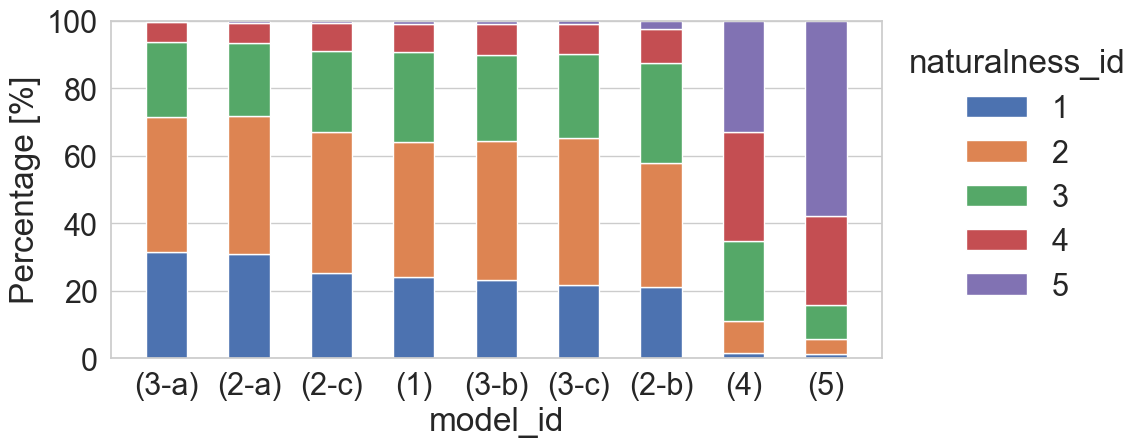

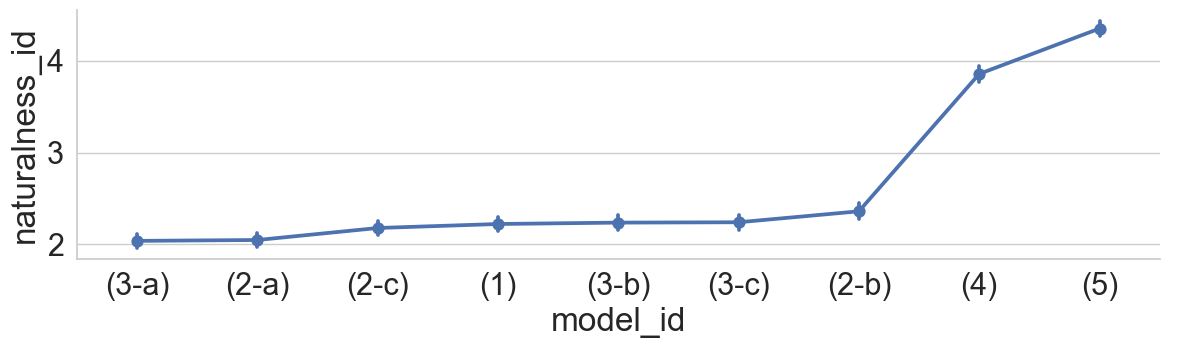

In [157]:
display_score_pct_bar_plot(
    df_answer=df_answer,
    df_summary_stats=df_summary_stats_naturalness,
    colname="naturalness_id",
    # save_path="./figs/nat_score_pct.png",
    save_path=str(save_dir / "nat_score_pct.png"),
)

display_mean_point_plot(
    df_answer=df_answer,
    df_summary_stats=df_summary_stats_naturalness,
    t_value=t_value,
    colname="naturalness_id",
    # save_path="./figs/nat_summary_stats.png",
    save_path=str(save_dir / "nat_summary_stats.png"),
)

In [158]:
df_htest_result_naturalness = hypothesis_testing(
    df_summary_stats=df_summary_stats_naturalness,
    df_answer=df_answer,
    colname="naturalness",
    alpha=alpha,
)

In [159]:
df_htest_result_naturalness.pivot(
    values=["ttest_naturalness_pvalue_corrected_bonf"],
    index="model_id_high",
    columns="model_id_low",
)

model_id_high,(4),(2-b),(3-c),(3-b),(1),(2-c),(2-a),(3-a)
str,f64,f64,f64,f64,f64,f64,f64,f64
"""(5)""",1.1910e-14,8.4458e-168,6.1921e-193,1.2207e-190,2.0556e-193,6.6880e-200,6.9837e-219,1.0219e-221
"""(4)""",null,8.7377e-100,4.3631e-119,6.3226e-118,3.5492e-120,8.0632e-126,1.0641e-142,8.2586e-145
"""(2-b)""",null,null,0.799562,0.719512,0.372448,0.040963,0.000002,8.5059e-7
"""(3-c)""",null,null,null,1.0,1.0,1.0,0.011577,0.005718
"""(3-b)""",null,null,null,null,1.0,1.0,0.016726,0.008498
"""(1)""",null,null,null,null,null,1.0,0.040092,0.021324
"""(2-c)""",null,null,null,null,null,null,0.380162,0.231751
"""(2-a)""",null,null,null,null,null,null,null,1.0


In [160]:
df_htest_result_naturalness.pivot(
    values=["ttest_naturalness_is_rejected_bonf"],
    index="model_id_high",
    columns="model_id_low",
)

model_id_high,(4),(2-b),(3-c),(3-b),(1),(2-c),(2-a),(3-a)
str,bool,bool,bool,bool,bool,bool,bool,bool
"""(5)""",true,true,true,true,true,true,true,true
"""(4)""",null,true,true,true,true,true,true,true
"""(2-b)""",null,null,false,false,false,true,true,true
"""(3-c)""",null,null,null,false,false,false,true,true
"""(3-b)""",null,null,null,null,false,false,true,true
"""(1)""",null,null,null,null,null,false,true,true
"""(2-c)""",null,null,null,null,null,null,false,false
"""(2-a)""",null,null,null,null,null,null,null,false


In [161]:
df_htest_result_naturalness.pivot(
    values=["ttest_naturalness_pvalue_corrected_bh"],
    index="model_id_high",
    columns="model_id_low",
)

model_id_high,(4),(2-b),(3-c),(3-b),(1),(2-c),(2-a),(3-a)
str,f64,f64,f64,f64,f64,f64,f64,f64
"""(5)""",7.9398e-16,1.2065e-168,1.2384e-193,2.0344e-191,5.1391e-194,2.2293e-200,3.4918e-219,1.0219e-221
"""(4)""",null,6.2412e-101,3.6359e-120,4.8635e-119,3.2265e-121,8.0632e-127,1.1823e-143,1.0323e-145
"""(2-b)""",null,null,0.027571,0.025697,0.01408,0.001707,1.4119e-7,5.3162e-8
"""(3-c)""",null,null,null,0.473743,0.404212,0.164133,0.000579,0.000318
"""(3-b)""",null,null,null,null,0.42013,0.179233,0.000796,0.000447
"""(1)""",null,null,null,null,null,0.252264,0.001707,0.000969
"""(2-c)""",null,null,null,null,null,null,0.01408,0.00927
"""(2-a)""",null,null,null,null,null,null,null,0.444785


In [162]:
df_htest_result_naturalness.pivot(
    values=["ttest_naturalness_is_rejected_bh"],
    index="model_id_high",
    columns="model_id_low",
)

model_id_high,(4),(2-b),(3-c),(3-b),(1),(2-c),(2-a),(3-a)
str,bool,bool,bool,bool,bool,bool,bool,bool
"""(5)""",true,true,true,true,true,true,true,true
"""(4)""",null,true,true,true,true,true,true,true
"""(2-b)""",null,null,true,true,true,true,true,true
"""(3-c)""",null,null,null,false,false,false,true,true
"""(3-b)""",null,null,null,null,false,false,true,true
"""(1)""",null,null,null,null,null,false,true,true
"""(2-c)""",null,null,null,null,null,null,true,true
"""(2-a)""",null,null,null,null,null,null,null,false


In [163]:
df_htest_result_naturalness.pivot(
    values=["mannwhitneyu_naturalness_pvalue_corrected_bonf"],
    index="model_id_high",
    columns="model_id_low",
)

model_id_high,(4),(2-b),(3-c),(3-b),(1),(2-c),(2-a),(3-a)
str,f64,f64,f64,f64,f64,f64,f64,f64
"""(5)""",2.1567e-16,2.4708e-121,2.5597e-131,1.0934e-130,9.6735e-132,5.8567e-134,5.7559e-140,3.0369e-141
"""(4)""",null,4.6924e-82,2.2048e-94,1.8108e-93,7.1690e-95,3.0419e-98,6.6145e-108,5.5823e-109
"""(2-b)""",null,null,1.0,0.950877,0.583893,0.0625,0.000005,0.000003
"""(3-c)""",null,null,null,1.0,1.0,1.0,0.009633,0.00713
"""(3-b)""",null,null,null,null,1.0,1.0,0.016414,0.012193
"""(1)""",null,null,null,null,null,1.0,0.033464,0.02535
"""(2-c)""",null,null,null,null,null,null,0.358196,0.285296
"""(2-a)""",null,null,null,null,null,null,null,1.0


In [164]:
df_htest_result_naturalness.pivot(
    values=["mannwhitneyu_naturalness_is_rejected_bonf"],
    index="model_id_high",
    columns="model_id_low",
)

model_id_high,(4),(2-b),(3-c),(3-b),(1),(2-c),(2-a),(3-a)
str,bool,bool,bool,bool,bool,bool,bool,bool
"""(5)""",true,true,true,true,true,true,true,true
"""(4)""",null,true,true,true,true,true,true,true
"""(2-b)""",null,null,false,false,false,false,true,true
"""(3-c)""",null,null,null,false,false,false,true,true
"""(3-b)""",null,null,null,null,false,false,true,true
"""(1)""",null,null,null,null,null,false,true,true
"""(2-c)""",null,null,null,null,null,null,false,false
"""(2-a)""",null,null,null,null,null,null,null,false


In [165]:
df_htest_result_naturalness.pivot(
    values=["mannwhitneyu_naturalness_pvalue_corrected_bh"],
    index="model_id_high",
    columns="model_id_low",
)

model_id_high,(4),(2-b),(3-c),(3-b),(1),(2-c),(2-a),(3-a)
str,f64,f64,f64,f64,f64,f64,f64,f64
"""(5)""",1.4378e-17,3.5297e-122,5.1194e-132,1.8224e-131,2.4184e-132,1.9522e-134,2.8780e-140,3.0369e-141
"""(4)""",null,3.3517e-83,1.8374e-95,1.3929e-94,6.5173e-96,3.0419e-99,7.3494e-109,6.9779e-110
"""(2-b)""",null,null,0.036102,0.03396,0.021626,0.002604,2.7351e-7,1.9022e-7
"""(3-c)""",null,null,null,0.467721,0.423368,0.160696,0.000507,0.000396
"""(3-b)""",null,null,null,null,0.443671,0.182403,0.000782,0.00061
"""(1)""",null,null,null,null,null,0.237696,0.001455,0.001152
"""(2-c)""",null,null,null,null,null,null,0.013777,0.011412
"""(2-a)""",null,null,null,null,null,null,null,0.467721


In [166]:
df_htest_result_naturalness.pivot(
    values=["mannwhitneyu_naturalness_is_rejected_bh"],
    index="model_id_high",
    columns="model_id_low",
)

model_id_high,(4),(2-b),(3-c),(3-b),(1),(2-c),(2-a),(3-a)
str,bool,bool,bool,bool,bool,bool,bool,bool
"""(5)""",true,true,true,true,true,true,true,true
"""(4)""",null,true,true,true,true,true,true,true
"""(2-b)""",null,null,true,true,true,true,true,true
"""(3-c)""",null,null,null,false,false,false,true,true
"""(3-b)""",null,null,null,null,false,false,true,true
"""(1)""",null,null,null,null,null,false,true,true
"""(2-c)""",null,null,null,null,null,null,true,true
"""(2-a)""",null,null,null,null,null,null,null,false
